# LAB: Stochastic Gradient Descent

The objective of this lab session is to implement:
- Stochastic gradient descent with constant stepsizes
- Stochastic gradient descent with shrinking stepsizes
- Stochastic gradient descent with sampling with/without replacement
- Stochastic gradient descent with averaging 
- SAG, Stochastic average gradient descent

and compare your implementation with gradient descent.

Throughout the notebook you will find commented boxes like this one

In [77]:
### TODO ###   
# please implement blabla
#############

These boxes need to be replaced by code as explained in the boxes.
Solutions will online tomorrow. Good luck!

Robert Gower

In [78]:
%matplotlib inline

In [79]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top w, b_i) + \frac \lambda 2 \|w\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(w)
$$
where
$$
f_i(w) = \ell(x_i^\top w, y_i) + \frac \lambda 2 \|w\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(w) = (x_i^\top w - y_i) a_i + \lambda w
$$
and
$$
\nabla f_i(w) = - \frac{y_i}{1 + \exp(y_i x_i^\top w)} x_i + \lambda w.
$$

Denote by $L$ the Lipschitz constant of $f$ and $X = [x_1, \ldots, x_n].$
One can see easily that for linear regression
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{n} + \lambda 
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{4 n} + \lambda 
$$
For full-gradient methods, the theoretical step-size is $1 / L$.

We now introduce a class that will be used for the solvers.

In [80]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    def grad(self, w):
        ### TODO ###   
        # calculate the gradient of f
        #############
        return 0
    
    def f(self, w):
        return norm(self.X.dot(w) - y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
 
    def f_i(self, i, w):
        return norm(self.X[i].dot(w) - y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.
    
    def grad_i(self, i, w):
        ### TODO ###   
        # calculate the gradient of f_i
        #############
        return 0

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        return L

In [81]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
    
    def grad(self, w):
        ### TODO ###   
        # calculate the gradient of f
        #############
        return 0

    def f(self, w):
        bAx = self.y * np.dot(self.X, w)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(w) ** 2 / 2.
    
    def f_i(self,i, w):
        bAx_i = self.y[i] * np.dot(self.X[i], w)
        return np.log(1. + np.exp(- bAx_i)) + self.lbda * norm(w) ** 2 / 2.
    
    def grad_i(self, i, w):
        ### TODO ###   
        # calculate the gradient of f_i
        #############
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        L = norm(self.X, ord=2) ** 2  / (4. * self.n) + self.lbda
        return L

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [82]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

    
def simu_linreg(w, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

In [83]:
def simu_logreg(w, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    X, y = simu_linreg(w, n, std=1., corr=0.5)
    return X, np.sign(y)

### Generate Data

In [84]:
d = 50
n = 1000
idx = np.arange(d)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

X, y = simu_linreg(w_model_truth, n, std=1., corr=0.1)
#X, y = simu_logreg(w_model_truth, n, std=1., corr=0.7)

### Choice of the model

In [85]:
lbda = 1. / n ** (0.5)
model = LinReg(X, y, lbda)
#model = LogReg(X, y, lbda)

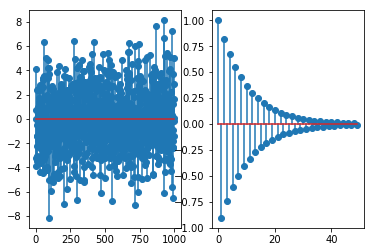

In [86]:
plt.subplot(1, 2, 1)
plt.stem(y); 
plt.subplot(1, 2, 2)
plt.stem(w_model_truth); 

In [87]:
from scipy.optimize import check_grad
# Check that the gradient and the loss numerically match
check_grad(model.f, model.grad, np.random.randn(d))

7.9656426959103772

ValueError: too many values to unpack (expected 1)

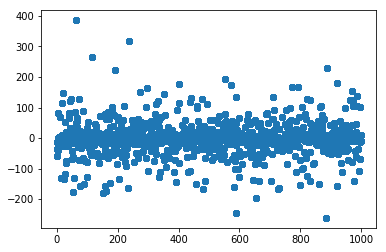

In [88]:
# Check that the gradient grad_i and the numerical gradient of f_i agree
grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    model.f_i(ind[0],w)
    grad_error.append((model.f_i( ind[0], w+eps*vec) - model.f_i( ind[0], w))/eps - np.dot(model.grad_i(ind[0],w),vec))
plt.stem(grad_error); 
print(np.mean(grad_error))

In [75]:
grad_error

[array([ 1.1108456,  1.1108456,  1.1108456,  1.1108456,  1.1108456,
         1.1108456,  1.1108456,  1.1108456,  1.1108456,  1.1108456,
         1.1108456,  1.1108456,  1.1108456,  1.1108456,  1.1108456,
         1.1108456,  1.1108456,  1.1108456,  1.1108456,  1.1108456,
         1.1108456,  1.1108456,  1.1108456,  1.1108456,  1.1108456,
         1.1108456,  1.1108456,  1.1108456,  1.1108456,  1.1108456,
         1.1108456,  1.1108456,  1.1108456,  1.1108456,  1.1108456,
         1.1108456,  1.1108456,  1.1108456,  1.1108456,  1.1108456,
         1.1108456,  1.1108456,  1.1108456,  1.1108456,  1.1108456,
         1.1108456,  1.1108456,  1.1108456,  1.1108456,  1.1108456]),
 array([ 4.07179173,  4.07179173,  4.07179173,  4.07179173,  4.07179173,
         4.07179173,  4.07179173,  4.07179173,  4.07179173,  4.07179173,
         4.07179173,  4.07179173,  4.07179173,  4.07179173,  4.07179173,
         4.07179173,  4.07179173,  4.07179173,  4.07179173,  4.07179173,
         4.07179173,  4.07

### Find a highly accurate solution using LBFGS method

In [ ]:
from scipy.optimize import fmin_l_bfgs_b

w_init = np.zeros(d)
w_min, obj_min, _ = fmin_l_bfgs_b(model.f, w_init, model.grad, args=(), pgtol=1e-30, factr =1e-30)

print(obj_min)
print(norm(model.grad(w_min)))

<a id='constant'></a> 

## 3. Implementing Stochastic Gradient Descent


### SGD

We recall that an iteration of SGD writes



**for** $t = 1, \ldots, T$ 
  
$\qquad$ Pick $i$ uniformly at random in $\{1, \ldots, n\}$
   
$\qquad \displaystyle
x_{t+1} \gets x_t - \eta_t \nabla f_i(x_t)
$
  
**end for**



Complete the code below. The inputs are
- n_iter: The number of iterations
- indices: an np.array of indices of length n_iter. The indices[k]  is the index of stochastic gradient that will be used on the kth iteration. 
- steps: an np.array of positive floats of length n_iter. The steps[k] is the stepsize used on the kth iteration. Typically decreasing stepsizes are used $\eta_t = \frac{\eta_0}{\sqrt{t+1}}$, where $\eta_0$ is a step-size to be tuned by hand.

- averaging_on: is a boolean which indicates if the output should be the average of the iterates.

The outputs are:
- x_output: The final x vector found by the algorithm or the average  $ \bar{x} = \frac{1}{T-t}\sum_{i=t}^T x_t$ if averaging is on
- objectives: A ndarray containing the sequence function values calculated during the iterations of the algorithm 
- errors: If x_min is not empty, errors is a ndarray containing the sequence of errors || x - x_min || of the algorithm. Otherwise errors should be empty.
*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [ ]:
def sgd(w0, model, indices, steps, w_min, n_iter=100, averaging_on=False ,verbose=True, start_late_averaging = 0):
    """Stochastic gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # average x
    w_average = w0.copy()
    # estimation error history
    errors = []
    err = 1.0
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w) 
    objectives.append(obj)
    if verbose:
        print("Lauching SGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter):
        ### TODO ###   
        ####################################
        # Compute the next iterate
        #  x_new[:]  = ........
        ####################################
        w[:] = w_new
        ####################################
        # Compute the average iterate 
        # x_average[:]  = ...x_average + .....
        ####################################
        if averaging_on:
            w_test = w_average.copy()
        else:
            w_test = w.copy()
        obj = model.f(w_test) 
        if np.any(w_min):
            err = norm(w_test - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if k % n_samples == 0 and verbose:
            if(sum(w_min)):
                print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
            else:
                print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)]))
    if averaging_on:
        w_output = w_average.copy()
    else:
        w_output = w.copy()    
    return w_output, np.array(objectives), np.array(errors)

In [ ]:
##Setup number of iterations
datapasses = 15  # number of sweeps through all the data. This means that there will datapasses*n stochastic gradient updates
niters = int(datapasses * n)

### SGD with constant step with replacement

In [ ]:
####################################
# Execute SGD with a constant stepsize. Please name the output as
# x_sgdcr, obj_sgdcr, err_sgdcr = sgd(...?....)
# HINT: You will have to guess a stepsizes and see if it works! Something around 0.005 should work here.
####################################

### SGD with $1/\sqrt(t)$ stepsizes with replacement

In [ ]:
####################################
# Execute SGD with a shrinking stepsize \eta_t = C/\sqrt(t). Please name the output as
# x_sgdsr, obj_sgdsr, err_sgdsr = sgd(.....?.....)
# HINT: You will have to guess C and see if it works! Something around C = 0.1 should work here.
####################################

In [ ]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdsr - obj_min, label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr , label="SGD const", lw=2)
plt.semilogy(err_sgdsr , label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

**Questions**

- Compare the solution you obtain for SGD with constant stepsizes and SGD with shrinking stepsizes. 
- Which one is faster in the beginning? Which reaches the "best" solution?
- What happens when is you use sampling without replacement instead? Hint: Do only one datapass, it's annoying to adapt this implementation for more than one datapass when sampling without replacement



## 5. Compare with averaging step

- Implement the average iterate output  
- Compare the solution you obtain for SGD with shrinking stepsizes and SGD with averaging. 
- What happens if you start averaging only the last n iterates? When is averaging useful?


In [ ]:
#############TODO#######################
# Execute SGD with averaging on and shrinking stepsize. Please name the output as
# x_sgdar, obj_sgdar, err_sgdar = sgd( .... )
# HINT: You can use the stepsize you found in the last step.
###############END TODO#####################

In [ ]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdsr - obj_min, label="SGD shrink", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD average", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdsr , label="SGD shrink", lw=2)
plt.semilogy(err_sgdar , label="SGD average", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## Compare with gradient descent

- Complete the code of gradient descent (GD) below
- How much more is the computational cost of a step of gradient descent with respect to the computational cost of a SGD step?  How many steps of gradient descent should you take so that the total computational complexity is equivalent to datapasses * n steps of SGD ? 
- Compare GD with SGD, where on the $x$-axis of the plot you the total computational effort spent
- What happens if you increase the number of datapasses?

In [ ]:
def gd(w0, model, step, w_min =[], n_iter=100, verbose=True):
    """Gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # estimation error history
    errors = []
    err = 1.
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w) 
    objectives.append(obj)
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter ):
        ##### TODO ######################
        ##### Compute gradient step update
        #####   w_new[:] = ...
        ##### END TODO ##################
        w[:] = w_new
        obj = model.f(w) 
        if (sum(w_min)):
            err = norm(w - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return w, np.array(objectives), np.array(errors)

In [ ]:
#############TODO#######################
# Calculate the number of iterations of GD so that the total computational effort is the same as your execution of SGD.
# gditerations = .....
# HINT: Each iteration of the GD algorithm calculates n stochastic gradients!
##############END TODO######################

In [ ]:
##############TODO######################
# Execute the gradient algorithm. Please name the output as
# x_gd, obj_gd, err_gd = gd(.....)
# Hint: Remember the stepsize of gradient descent should be equal to 1/L, where L is this Lipshitz constant of f
###############END TODO#####################

In [ ]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(complexityofGD, obj_gd - obj_min, label="gd", lw=2)
plt.semilogy(obj_sgdsr - obj_min, label="sgd", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("# SGD iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
# Distance to the minimum on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(complexityofGD, err_gd, label="gd", lw=2)
plt.semilogy(err_sgdsr , label="sgd", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("# SGD iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## SGD without replacement

-Execute SGD where the indices of the data points are sampled *without* replacement over each datapass

In [ ]:
#############TODO#######################
# Execute SGD with averaging on and shrinking stepsize. Please name the output as
# w_sgdsw, obj_sgdsw, err_sgdsw = sgd(....)
# HINT: You should use numpy.matlib's repmat function to  
#import numpy.matlib
# With replacement
#indices = np.matlib.repmat(... )
###############END TODO#####################

In [ ]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(obj_sgdsr - obj_min, label="SGD replace", lw=2)
plt.plot(obj_sgdsw - obj_min, label="SGD withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(err_sgdsr , label="SGD replace", lw=2)
plt.plot(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
g_t \gets \frac 1n \sum_{i=1}^n J_i^t
$$
where 
$$
J_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    J_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta\, J_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [ ]:
def sag(w0, model, indices,  step=1., w_min =0, n_iter=100, verbose = True): 
  #  (w0, model, indices, steps, w_min, n_iter=100, averaging_on=False ,verbose=True, start_late_averaging = 0):
    """Stochastic average gradient algorithm."""
    w = w0.copy()
    # Old gradients
    n_samples, n_features = X.shape
    gradient_memory = np.zeros((n_samples, n_features))
    averaged_gradient = np.zeros(n_features)
    # estimation error history
    errors = []
    err = 1.
    # objective history
    objectives = []
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    print("Lauching SAG solver...")
    print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))   
    for idx in range(n_iter):
        i = indices[idx]    
        ### TODO ######
        ## Implement a step of the SAG method
        # w[:] -= ....
        ### END OF TODO
        obj = model.f(w) 
        if (sum(w_min)):
            err = norm(w - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if idx % n_samples == 0 and verbose:
            print(' | '.join([("%d" % idx).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return w, np.array(objectives), np.array(errors)

In [ ]:
##############TODO######################
# Execute the gradient algorithm. Please name the output as
# w_sag, obj_sag, err_sag = sag( ... )
# Hint: Remember the stepsize of SAGA should be equal to 1/L_max, where L_max = max L_i  and L_i is the smoothness constant of f_i
###############END TODO#####################

In [ ]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdsw - obj_min, label="SGD withoutreplace", lw=2)
plt.semilogy(complexityofGD, obj_gd - obj_min, label="GD", lw=2)
plt.semilogy(obj_sag - obj_min, label="SAG", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.semilogy(complexityofGD, err_gd , label="GD", lw=2)
plt.semilogy(err_sag , label="SAG", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

In [ ]:
###### TODO ###### 
## Compare SGD, GD and SAG in terms of test error after performing 15 passes over the data. That is, 
# datapasses = 15
# Then plot the progression that
##  each method makes towards w_model_truth instead of w_min.
## Please name the output of the methods to
# w_sgdsw, obj_sgdsw, err_sgdsw = sgd(...  w_model_truth...)
# w_gd, obj_gd, err_gd          = gd(... w_model_truth...)
# w_sag, obj_sag, err_sag       = sag( ...  w_model_truth... )
##### TODO END
# What can you conclude? How is this plot different than the convergence to w_min? Was this to be expected?

In [ ]:
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.semilogy(complexityofGD, err_gd , label="GD", lw=2)
plt.semilogy(err_sag , label="SAG", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to true model", fontsize=14)
plt.legend()

## THE END!